In [3]:
import numpy as np #importing libraries
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

from pathlib import Path
Path('/kaggle/working/oral-diseases/').mkdir(parents=True, exist_ok=True)
import shutil
import os

# Caries.
caries_file_path = Path('/kaggle/input/oral-diseases/Data caries/Data caries/caries augmented data set/preview')
caries_new_directory = Path('/kaggle/working/oral-diseases/caries')
shutil.copytree(caries_file_path, caries_new_directory)

# Calculus
calculus_file_path = Path('/kaggle/input/oral-diseases/Calculus/Calculus')
calculus_new_directory = Path('/kaggle/working/oral-diseases/calculus')
shutil.copytree(calculus_file_path, calculus_new_directory)

#Gingivitis
gingivitis_file_path = Path('/kaggle/input/oral-diseases/Gingivitis/Gingivitis')
gingivitis_new_directory = Path('/kaggle/working/oral-diseases/gingivitis')
shutil.copytree(gingivitis_file_path, gingivitis_new_directory)

#Tooth Discoloration
toothDiscoloration_file_path = Path('/kaggle/input/oral-diseases/Tooth Discoloration/Tooth Discoloration /Tooth_discoloration_augmented_dataser/preview')
toothDiscoloration_new_directory = Path('/kaggle/working/oral-diseases/toothDiscoloration')
shutil.copytree(toothDiscoloration_file_path, toothDiscoloration_new_directory)

#ulcer
ulcer_file_path = Path('/kaggle/input/oral-diseases/Mouth Ulcer/Mouth Ulcer/Mouth_Ulcer_augmented_DataSet/preview')
ulcer_new_directory = Path('/kaggle/working/oral-diseases/ulcer')
shutil.copytree(ulcer_file_path, ulcer_new_directory)

#hypodontia
hypodontia_file_path = Path('/kaggle/input/oral-diseases/hypodontia/hypodontia')
hypodontia_new_directory = Path('/kaggle/working/oral-diseases/hypodontia')
shutil.copytree(hypodontia_file_path, hypodontia_new_directory)


build_dir = "/kaggle/working/oral-diseases"
caries_dir = os.path.join(build_dir,'caries')
gingivitis_dir = os.path.join(build_dir,'gingivitis')
toothDiscoloration_dir = os.path.join(build_dir,'toothDiscoloration')
ulcers_dir = os.path.join(build_dir,'ulcer')
hypodontia_dir = os.path.join(build_dir,'hypodontia')
calculus_dir = os.path.join(build_dir,'calculus')
os.listdir(build_dir)

['calculus',
 'gingivitis',
 'toothDiscoloration',
 'ulcer',
 'caries',
 'hypodontia']

In [4]:
import os
import torch
from pathlib import Path
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T

torch.manual_seed(2024)


class CustomDataset(Dataset):
    
    def __init__(self, root, transformations=None):
        self.transformations = transformations
        # Use a more inclusive pattern for image file extensions and names
        self.im_paths = sorted( 
                       glob(f"{root}/**/*.[jp][np]eg", recursive=True) + 
                       glob(f"{root}/**/*.[Jj][Pp][Gg]", recursive=True) )
        
        # Update class mapping based on actual names
        self.cls_names = {
            'caries': 0,
            'calculus': 1,
            'gingivitis': 2,
            'toothDiscoloration': 3,
            'hypodontia': 4,
            'ulcer':5
        }
        
        self.cls_counts = {name: 0 for name in self.cls_names}  # Initialize class counts
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name in self.cls_names:  # Check if the class is mapped
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        # Get the folder name one level up in the directory structure
        class_name = os.path.basename(os.path.dirname(path))
        return class_name
    
    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        class_name = self.get_class(im_path)
        
        # Ground truth label
        gt = self.cls_names.get(class_name, -1)  # Get the class index; return -1 if not found
        
        if self.transformations is not None:
            im = self.transformations(im)
        
        return im, gt

def get_dls(root, transformations, bs, split=[0.9, 0.05, 0.05], ns=4):
    
    ds = CustomDataset(root=root, transformations=transformations)
    print("Class counts:", ds.cls_counts)
    
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    
    tr_ds, vl_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, vl_len, ts_len])
    
    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=ns)
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=ns)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=ns)
    
    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "/kaggle/working/oral-diseases"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=tfs, bs=32)

print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
print(classes)


Class counts: {'caries': 2382, 'calculus': 1296, 'gingivitis': 2349, 'toothDiscoloration': 1834, 'hypodontia': 1251, 'ulcer': 2541}
328
19
584
{'caries': 0, 'calculus': 1, 'gingivitis': 2, 'toothDiscoloration': 3, 'hypodontia': 4, 'ulcer': 5}


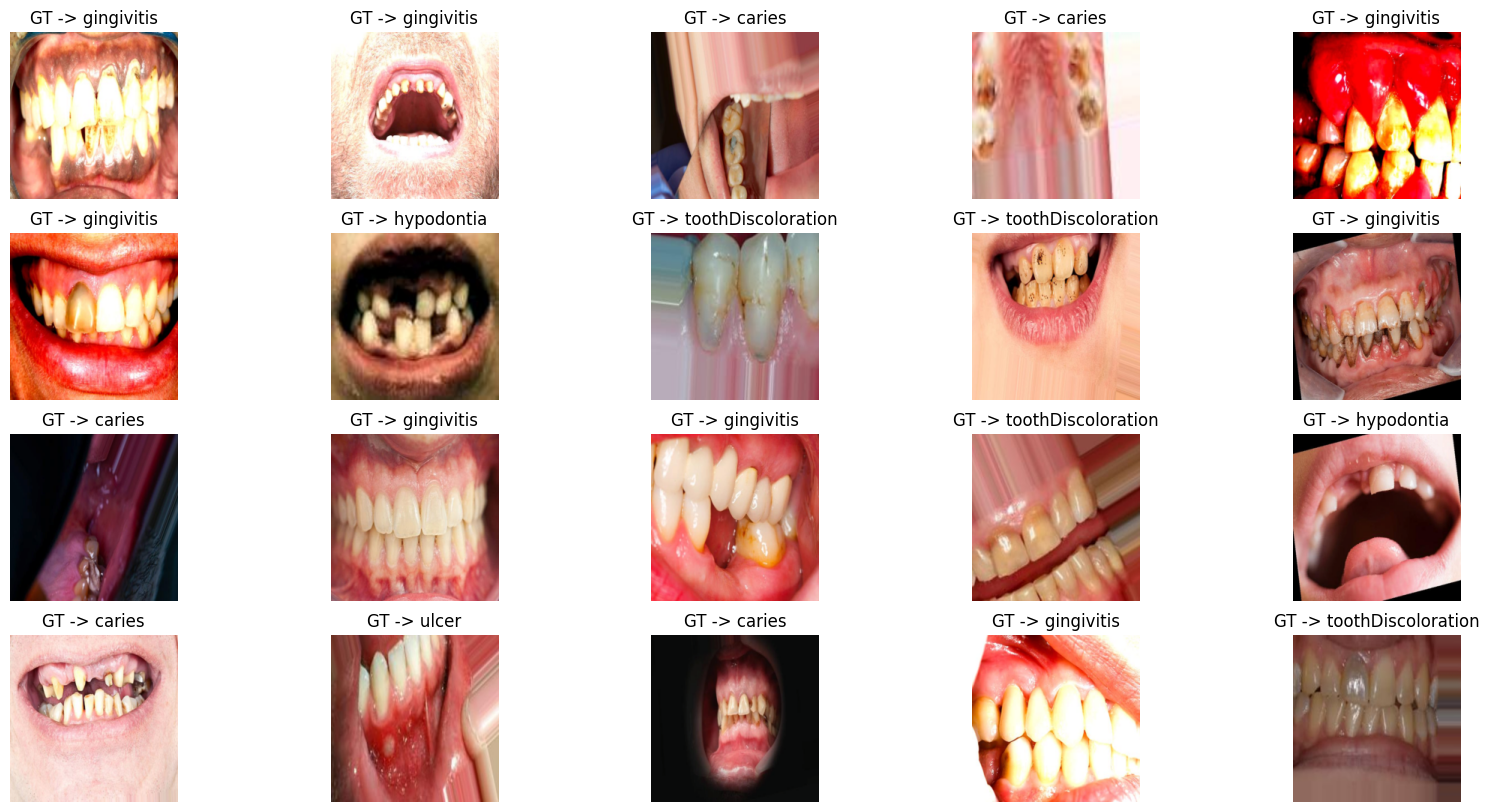

In [5]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

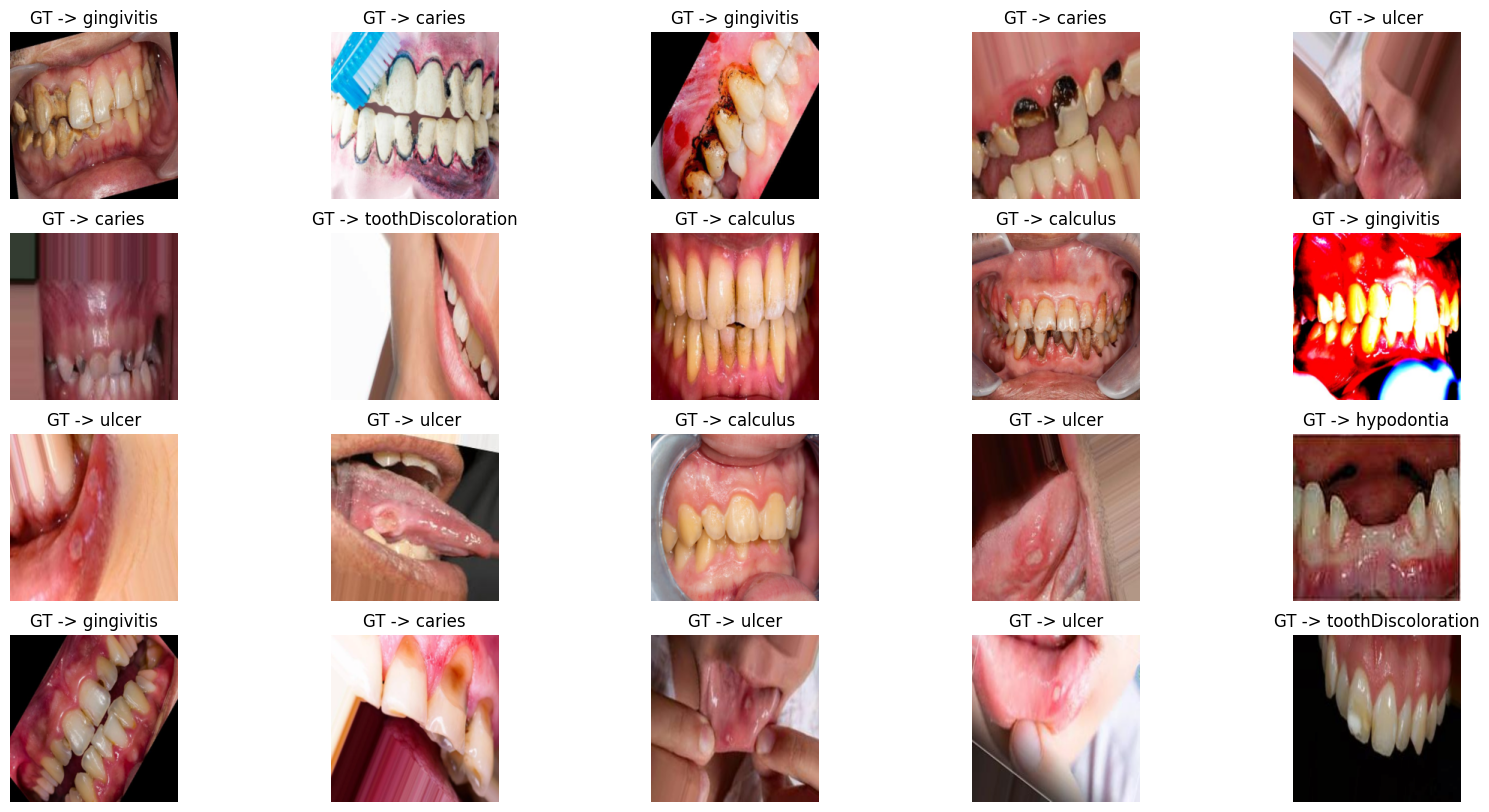

In [6]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

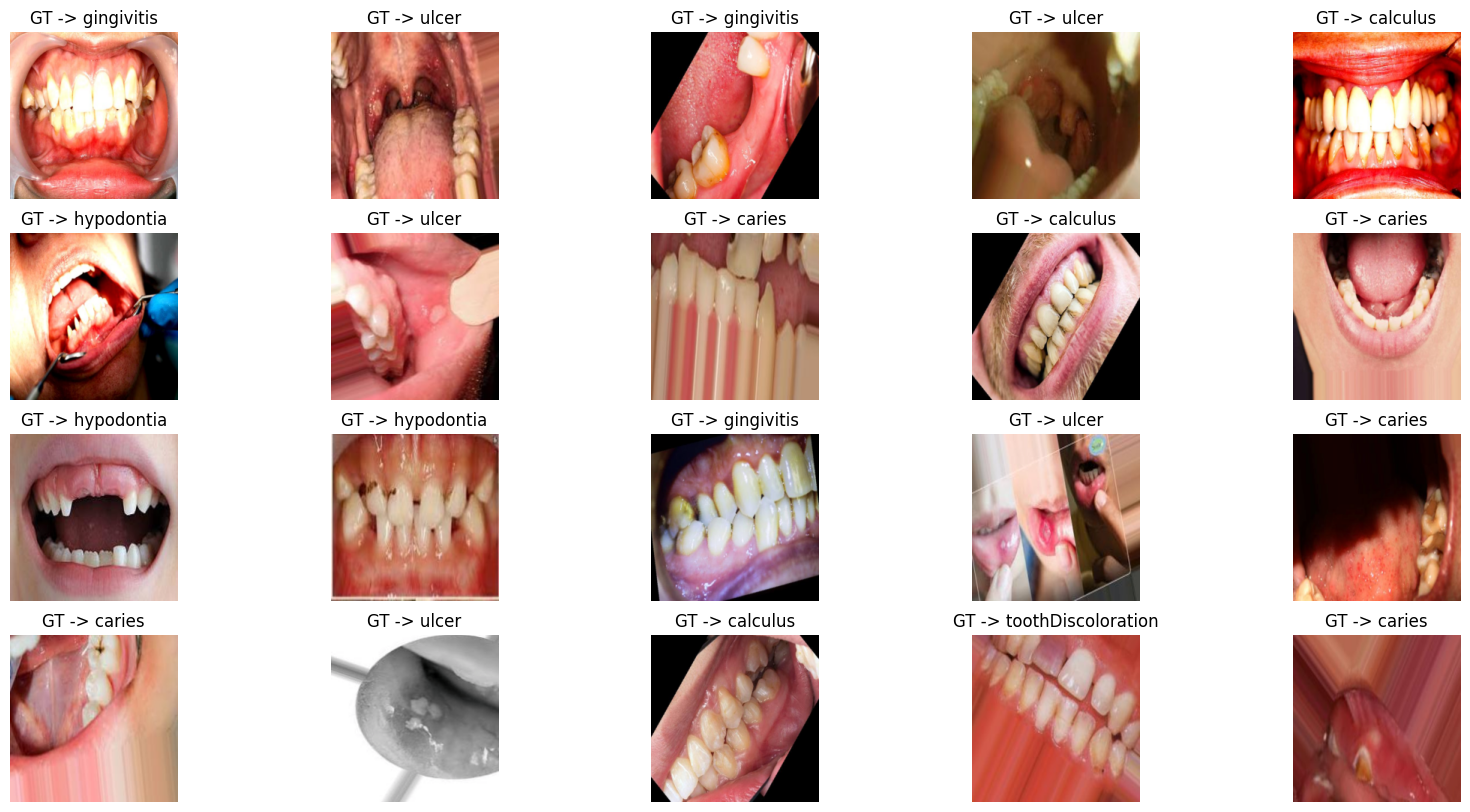

In [7]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


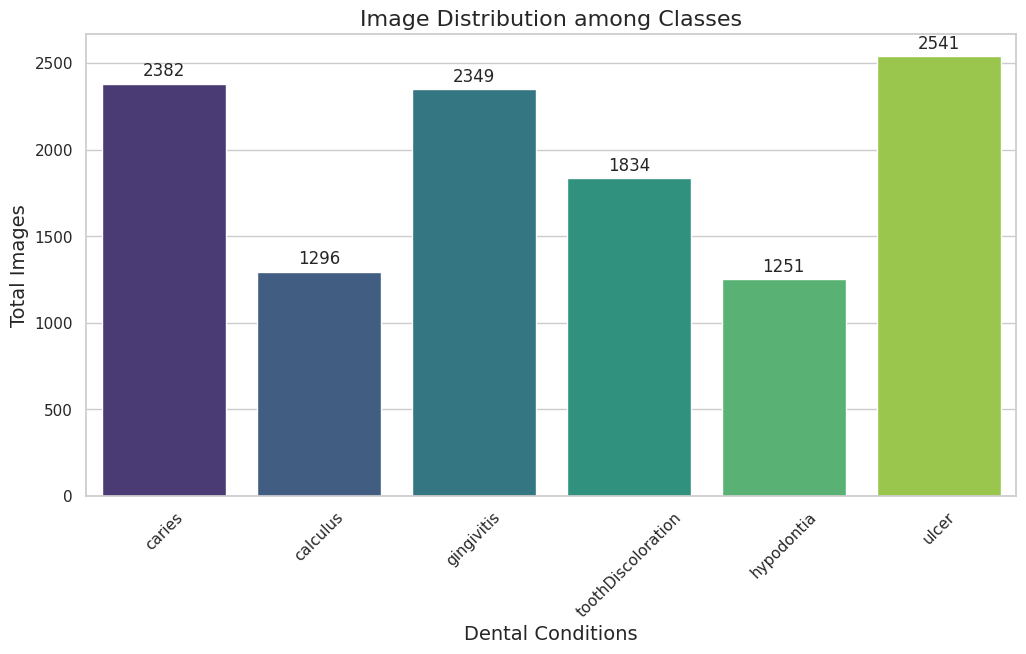

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def data_analysis(root, transformations):
    
    ds = CustomDataset(root=root, transformations=transformations)
    cls_counts = ds.cls_counts
    cls_names = list(cls_counts.keys())
    counts = list(cls_counts.values())

    # Use Seaborn for styling and Viridis color palette
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    # Creating the barplot with Viridis palette
    barplot = sns.barplot(x=cls_names, y=counts, palette="viridis")
    
    # Adding the text on top of each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', 
                         xytext=(0, 9), textcoords='offset points')
    
    # Setting titles and labels
    plt.xlabel("Dental Conditions", fontsize=14)
    plt.ylabel("Total Images", fontsize=14)
    plt.title("Image Distribution among Classes", fontsize=16)
    plt.xticks(rotation=45)
    
    # Save the plot as an image
    plt.savefig('imageDistribution.png')
    
    # Display the plot
    plt.show()

# Call the function
data_analysis(root=root, transformations=tfs)


<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>✨ 4. AI Model Train and Validation ✨</b></font>
</div>

In [13]:
import timm, torchmetrics
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))  

def train_setup(m): return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "oral", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)
    
for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...


328it [01:09,  4.70it/s]

1-epoch train process is completed!
1-epoch train loss          -> 0.584
1-epoch train accuracy      -> 0.758
1-epoch train f1-score      -> 0.758


1-epoch validation process is completed!
1-epoch validation loss     -> 0.331
1-epoch validation accuracy -> 0.861
1-epoch validation f1-score -> 0.853


328it [01:09,  4.71it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.271
2-epoch train accuracy      -> 0.887
2-epoch train f1-score      -> 0.887


2-epoch validation process is completed!
2-epoch validation loss     -> 0.269
2-epoch validation accuracy -> 0.899
2-epoch validation f1-score -> 0.896


328it [01:09,  4.70it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.211
3-epoch train accuracy      -> 0.907
3-epoch train f1-score      -> 0.907


3-epoch validation process is completed!
3-epoch validation loss     -> 0.244
3-epoch validation accuracy -> 0.895
3-epoch validation f1-score -> 0.900


328it [01:09,  4.70it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.178
4-epoch train accuracy      -> 0.919
4-epoch train f1-score      -> 0.919


4-epoch validation process is completed!
4-epoch validation loss     -> 0.205
4-epoch validation accuracy -> 0.924
4-epoch validation f1-score -> 0.921


328it [01:09,  4.70it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.167
5-epoch train accuracy      -> 0.928
5-epoch train f1-score      -> 0.927


5-epoch validation process is completed!
5-epoch validation loss     -> 0.210
5-epoch validation accuracy -> 0.911
5-epoch validation f1-score -> 0.914


328it [01:09,  4.70it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.149
6-epoch train accuracy      -> 0.932
6-epoch train f1-score      -> 0.932


6-epoch validation process is completed!
6-epoch validation loss     -> 0.331
6-epoch validation accuracy -> 0.888
6-epoch validation f1-score -> 0.886
Loss value did not decrease for 1 epochs


328it [01:09,  4.70it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.146
7-epoch train accuracy      -> 0.934
7-epoch train f1-score      -> 0.934


7-epoch validation process is completed!
7-epoch validation loss     -> 0.276
7-epoch validation accuracy -> 0.888
7-epoch validation f1-score -> 0.893
Loss value did not decrease for 2 epochs


328it [01:09,  4.70it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.134
8-epoch train accuracy      -> 0.939
8-epoch train f1-score      -> 0.939


8-epoch validation process is completed!
8-epoch validation loss     -> 0.165
8-epoch validation accuracy -> 0.924
8-epoch validation f1-score -> 0.921


328it [01:09,  4.70it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.135
9-epoch train accuracy      -> 0.936
9-epoch train f1-score      -> 0.936


9-epoch validation process is completed!
9-epoch validation loss     -> 0.202
9-epoch validation accuracy -> 0.916
9-epoch validation f1-score -> 0.919
Loss value did not decrease for 3 epochs


328it [01:09,  4.70it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.119
10-epoch train accuracy      -> 0.943
10-epoch train f1-score      -> 0.943


10-epoch validation process is completed!
10-epoch validation loss     -> 0.221
10-epoch validation accuracy -> 0.876
10-epoch validation f1-score -> 0.882
Loss value did not decrease for 4 epochs


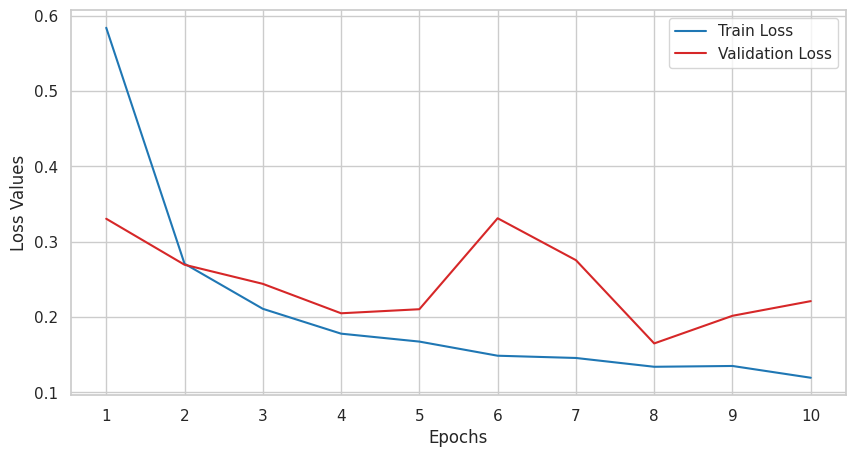

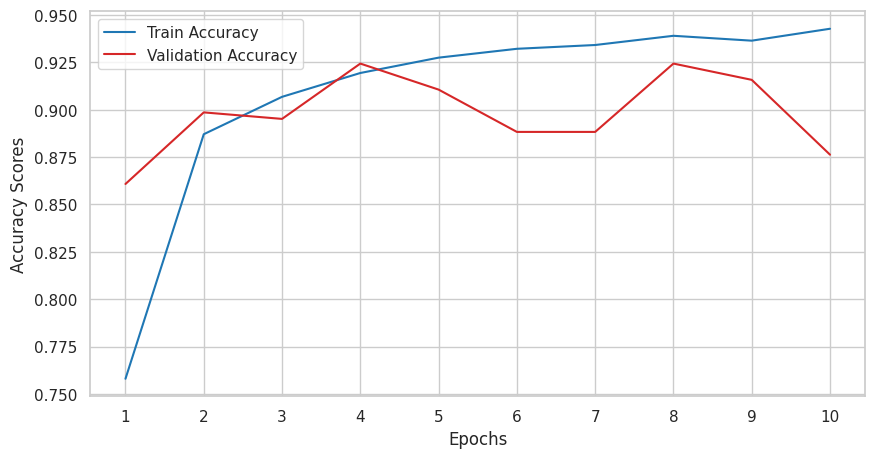

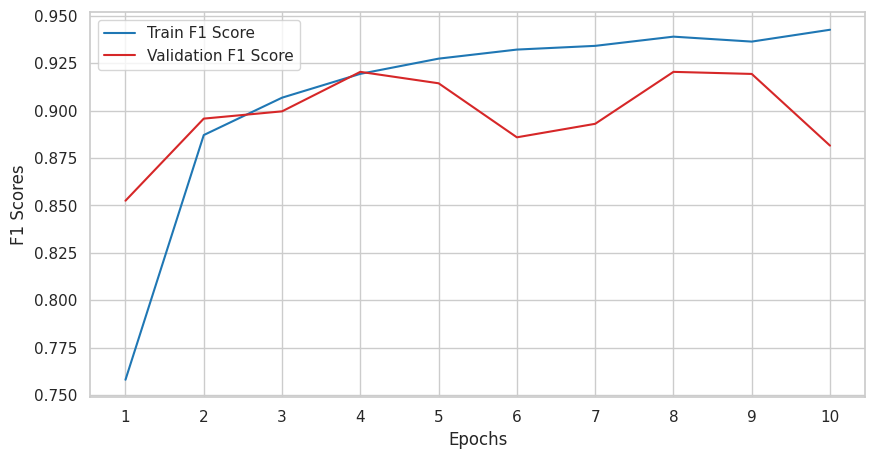

In [26]:
class PlotLearningCurves:
    
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        
        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s
        
    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)
        
    def create_figure(self): plt.figure(figsize = (10, 5))
    
    def decorate(self, ylabel, xlabel = "Epochs"): 
        
        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()      
        
    def visualize(self):
        
        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "tab:blue", color_2 = "tab:red"); self.decorate(ylabel = "Loss Values")
        
        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "tab:blue", color_2 = "tab:red")
        self.decorate(ylabel = "Accuracy Scores")
        
        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "tab:blue", color_2 = "tab:red"); self.decorate(ylabel = "F1 Scores")
        
PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()

584it [00:10, 55.79it/s]


Accuracy of the model on the test data -> 0.916


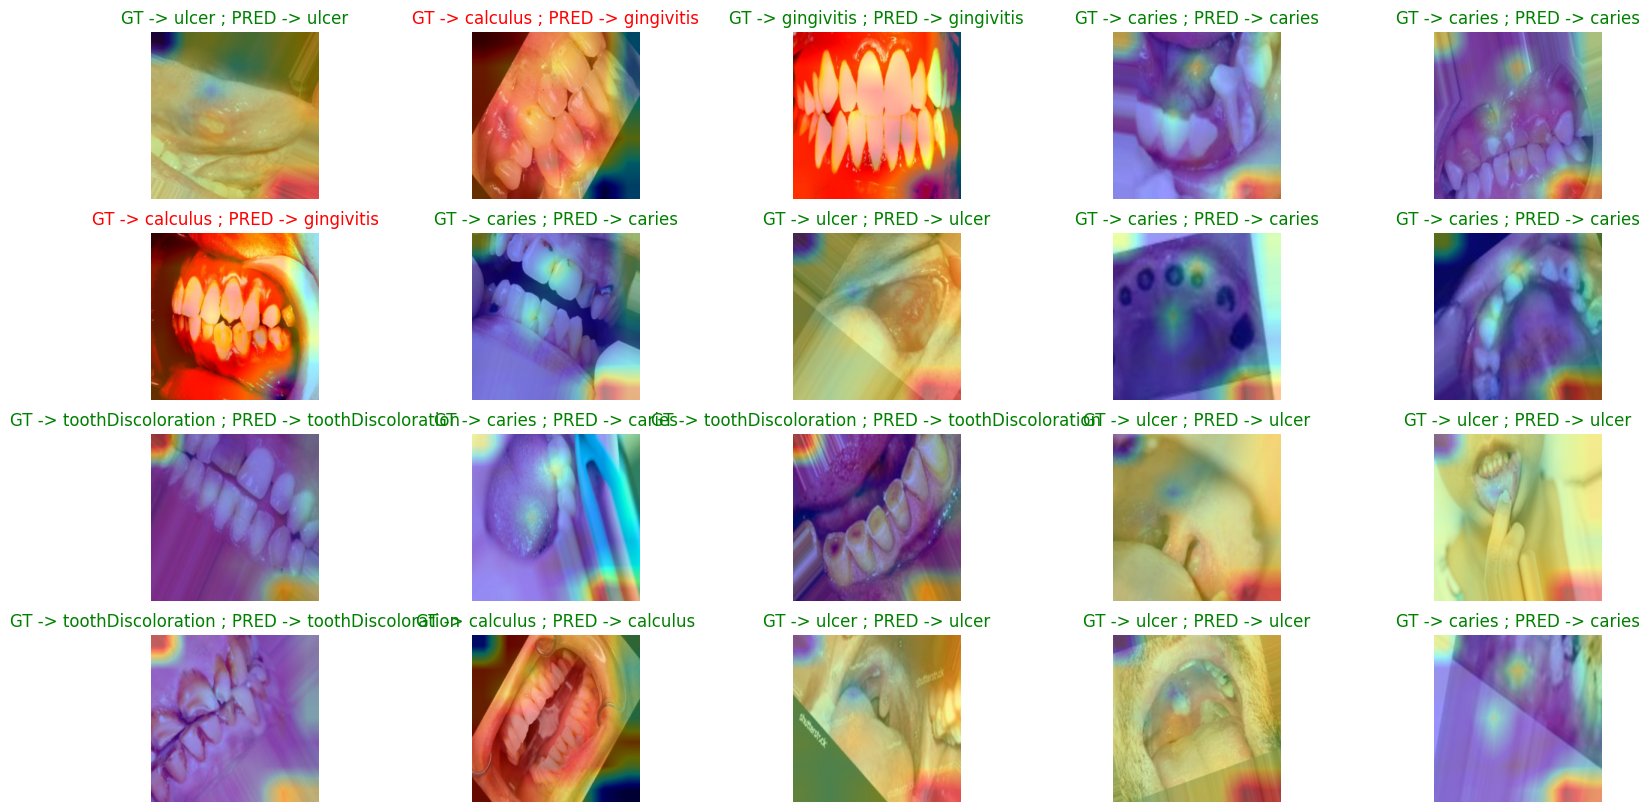

In [11]:
import cv2
class SaveFeatures():
    
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):
    
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    
    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):
    
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())
    
    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        
        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")
        
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {preds}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)